In [1]:
train_path = "../new_train/new_train"
val_path = "../new_val_in/new_val_in"
submission_path = "../sample_submission.csv"
submission_dir = "../submissions"

In [2]:
NUM_EPOCH = 1
BATCH_SIZE = 64
LEARNING_RATE = 1e-3

In [3]:
import os
import pickle
import numpy as np
from glob import glob
import pandas as pd
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

# Data

In [4]:
class ArgoverseDataset(Dataset):
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
        
        if self.transform:
            data = self.transform(data)

        return data

Train dataset has 205942 data samples, each sample is a dictionary that contains information on a individual scene. Each dictionary (scene) contains 11 different fields. More resources here to understand the dataset: https://www.kaggle.com/c/cse151b-spring/discussion/233734

In [5]:
train = ArgoverseDataset(data_path=train_path)
val = ArgoverseDataset(data_path=val_path)
train_0 = train[0]
track_id = train_0['track_id']
car_mask = train_0['car_mask']
actual_objects = track_id[car_mask.reshape([-1]).astype(int)]
actual_objects

array([[['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ...,
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007']],

       [['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ...,
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007']],

       [['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ...,
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007'],
        ['00000000-0000-0000-0000-000000000007']],

       ...,

       [['00000000-0000-0000-0000-00000000

In [6]:
def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """  
    agent_idx = np.where(train_0["agent_id"] == np.unique(train_0["track_id"].flatten()))[0][0]
    inp = np.array([np.hstack(
        [scene['p_in'][agent_idx], 
         scene['v_in'][agent_idx],
         ]
    ) for scene in batch])
    out = np.array([np.hstack(
        [scene['p_out'][agent_idx],
         scene['v_out'][agent_idx]]
    ) for scene in batch])
    inp = torch.FloatTensor(inp)
    out = torch.FloatTensor(out)
    return [inp, out]

train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_collate, num_workers=0)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle = False, collate_fn=my_collate, num_workers=0)
example = iter(train_loader)

# each example consists of: [inp tensor, out tensor], inp tensor has shape 64x19x4, out tensor has shape 
# 64x30x4. 64 is the batch size, each input in the batch is 19x4, which is two vectors stacked together: 
# the position vector (p_in) which is 19x2 and contains position information (x, y coordinates), and the
# velocity vector (v_in) which is 19x2 and contains velocity information (x, y velocity). These are position
# and velocities that lasted for 2 seconds, 10 samples are recorded per second (hence 19 samples)
# each output vector is 20x4, pretty much contain the same position and velocity information as the input
# tensor, except it will last for 3 seconds instead of 2, hence 30 samples. Our task is to try to predict 
# the output position and velocity.
example.next()

[tensor([[[ 3.2354e+03,  1.9295e+03,  2.5700e-01,  3.1313e-01],
          [ 3.2359e+03,  1.9298e+03,  4.6091e+00,  3.1098e+00],
          [ 3.2359e+03,  1.9299e+03,  8.8960e-01,  1.0443e+00],
          ...,
          [ 3.2431e+03,  1.9365e+03,  2.8242e+00,  1.9251e+00],
          [ 3.2434e+03,  1.9367e+03,  2.6001e+00,  1.8116e+00],
          [ 3.2439e+03,  1.9371e+03,  5.0465e+00,  4.3822e+00]],
 
         [[ 8.2398e+02,  2.0614e+03, -1.9209e-01, -1.3550e-01],
          [ 8.2398e+02,  2.0615e+03, -3.1030e-02,  5.0042e-02],
          [ 8.2398e+02,  2.0615e+03,  5.0020e-03,  4.2677e-01],
          ...,
          [ 8.2395e+02,  2.0616e+03, -4.7582e-01,  2.9586e-01],
          [ 8.2409e+02,  2.0614e+03,  1.4007e+00, -1.9915e+00],
          [ 8.2408e+02,  2.0613e+03, -1.2219e-01, -3.2250e-01]],
 
         [[ 3.0105e+03,  1.5922e+03, -4.0253e-01, -3.1084e-01],
          [ 3.0105e+03,  1.5922e+03, -8.0196e-02,  1.3128e-01],
          [ 3.0106e+03,  1.5922e+03,  9.4546e-01,  4.9641e-02],
    

In [7]:
submission = pd.read_csv(submission_path)
submission

,ID,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
0,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,9897,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3196,99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3197,9905,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3198,9910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Explore

In [8]:
train_0 = train[0]

In [9]:
train_0['p_in'].shape

(60, 19, 2)

dict_keys(['city', 'lane', 'lane_norm', 'scene_idx', 'agent_id', 'car_mask', 'p_in', 'v_in', 'p_out', 'v_out', 'track_id'])
(60, 19, 2) (60, 30, 2)
(60, 30, 1)
00000000-0000-0000-0000-000000000062


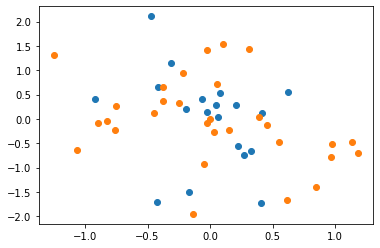

In [10]:
import matplotlib.pyplot as plt

scene = train[0]
print(train[0].keys())

pos_in = scene["v_in"]
pos_out = scene["v_out"]
print(pos_in.shape, pos_out.shape)
track_id = scene["track_id"]
print(track_id.shape)
car_id  = 2
agent_id = scene["agent_id"]
print(agent_id)
plt.scatter(pos_in[car_id,:,0], pos_in[car_id,:,1])
plt.scatter(pos_out[car_id,:,0], pos_out[car_id,:,1])

# Baseline (Constant velocity)

In [11]:
train_0 = train[2323]

In [12]:
train_0['p_in']
train_0['track_id'][:, :, 0]
train_0['agent_id']

'00000000-0000-0000-0000-000000014742'

In [13]:
train_0['p_in'][4]

array([[ 568.38769531, 2098.21240234],
       [ 568.30877686, 2095.91650391],
       [ 568.55822754, 2095.08422852],
       [ 568.50262451, 2093.97949219],
       [ 568.68048096, 2093.05029297],
       [ 568.45727539, 2091.95922852],
       [ 568.59118652, 2090.98071289],
       [ 568.79071045, 2090.078125  ],
       [ 568.73016357, 2088.91430664],
       [ 568.71337891, 2088.06567383],
       [ 568.86688232, 2086.9675293 ],
       [ 568.77008057, 2085.92822266],
       [ 568.71276855, 2084.92797852],
       [ 568.78063965, 2083.88330078],
       [ 568.89666748, 2082.72973633],
       [ 568.90222168, 2082.15283203],
       [ 568.89044189, 2081.23144531],
       [ 568.84240723, 2080.14941406],
       [ 568.82531738, 2079.04956055]])

In [14]:
train_0["agent_id"]

'00000000-0000-0000-0000-000000014742'

In [15]:
agent_idx = np.where(train_0["agent_id"] == np.unique(train_0["track_id"].flatten()))[0][0]

In [16]:
np.hstack([scene['p_in'][agent_idx], scene['v_in'][agent_idx]]).shape 

(19, 4)

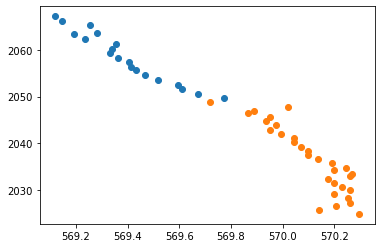

In [17]:
plt.scatter(train_0["p_in"][3][:, 0], train_0["p_in"][3][:, 1])
plt.scatter(train_0["p_out"][3][:, 0], train_0["p_out"][3][:, 1])

# Preprocessing

# Training

## constant velocity

In [18]:
def get_mean_velocity(coords: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Get mean velocity of the observed trajectory.
    Args:
        coords: Coordinates for the trajectory
    Returns:
        Mean velocity along x and y
    """
    vx, vy = (
        np.zeros((coords.shape[0], coords.shape[1] - 1)),
        np.zeros((coords.shape[0], coords.shape[1] - 1)),
    )

    for i in range(1, coords.shape[1]):
        vx[:, i - 1] = (coords[:, i, 0] - coords[:, i - 1, 0]) / 0.1
        vy[:, i - 1] = (coords[:, i, 1] - coords[:, i - 1, 1]) / 0.1
    vx = np.mean(vx, axis=1)
    vy = np.mean(vy, axis=1)

    return vx, vy


def predict(obs_trajectory: np.ndarray, vx: np.ndarray, vy: np.ndarray,
            pred_len: int) -> np.ndarray:
    """Predict future trajectory given mean velocity.
    Args:
        obs_trajectory: Observed Trajectory
        vx: Mean velocity along x
        vy: Mean velocity along y
        args: Arguments to the baseline
    Returns:
        pred_trajectory: Future trajectory
    """
    pred_trajectory = np.zeros((obs_trajectory.shape[0], pred_len, 2))

    prev_coords = obs_trajectory[:, -1, :]
    for i in range(pred_len):
        pred_trajectory[:, i, 0] = prev_coords[:, 0] + vx * 0.1
        pred_trajectory[:, i, 1] = prev_coords[:, 1] + vy * 0.1
        prev_coords = pred_trajectory[:, i]

    return pred_trajectory

In [19]:
df = pd.DataFrame()
# df['ID'] = submission['ID']
for i in range(1, 61):
    df[f'v{i}'] = np.zeros(len(submission))
    
for i, scene in tqdm(enumerate(val)):
    agent_id = scene['agent_id']
    track_ids = [track_id[0] for track_id in scene['track_id']]
    agent_ix = track_ids.index(agent_id)
    
    vx, vy = get_mean_velocity(val[i]['p_in'])
    predicted_trajectory = predict(val[i]['p_in'], vx, vy, 30)
    df.iloc[i] = predicted_trajectory[agent_ix].flatten()

3200it [00:14, 224.52it/s]


## Baseline LSTM

In [20]:
from torch import nn
from sklearn.preprocessing import StandardScaler

In [21]:
class MotionPlanningModel(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, output_feature=2, n_layers=1):
        super(MotionPlanningModel, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size = n_features, 
                            hidden_size = self.n_hidden,
                            num_layers = self.n_layers, 
#                             batch_first = True
                           )
        self.linear = nn.Linear(in_features=n_hidden, out_features=output_feature)
        
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size, self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        self.hidden = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        return x

In [27]:
class LSTM(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, output_feature=2, n_layers=1):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_size = n_features, 
                            hidden_size = self.n_hidden,
                            num_layers = self.n_layers, 
                            batch_first = True
                           )
        self.linear = nn.Linear(n_hidden, output_feature)
        
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.randn(self.n_layers, batch_size, self.n_hidden).to(device)
        cell_state = torch.randn(self.n_layers, batch_size, self.n_hidden).to(device)
        return (hidden_state, cell_state)
    
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        self.hidden = self.init_hidden(batch_size)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        out = self.linear(lstm_out)
        return out

In [28]:
# model training
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
model = LSTM(4, 8, 2)
model.to(device)
# model = MotionPlanningModel(4, 8, 2)

loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [29]:
# normalize input and output so that they rescale between 0 and 1
def normalize(vector):
    return ((vector - torch.mean(vector))/torch.std(vector)).reshape(-1, 1)
    

In [30]:
NUM_EPOCH = 10
for epoch in range(NUM_EPOCH):
    for i_batch, batch_data in enumerate(train_loader):
        inp, out = batch_data
        inp, out = inp.to(device), out.to(device)
        
        # we use this lstm to compute the first 19 samples of output
        out = out[:, :19, :2]
        
        # normalize input output to rescale between 0 and 1
       
        # forward
        y_pred = model(inp)
        loss = loss_fn(y_pred, out)
        
        # backward
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if i_batch % 200 == 0:
            print(f"Epoch {epoch+1}/{NUM_EPOCH}, batch {i_batch}/{len(train_loader)}, loss: {loss.item():.4f}")
        
        # visualization
        # show_sample_batch(sample_batch, agent_id)


Epoch 1/10, batch 0/3218, loss: 4811338.5000
Epoch 1/10, batch 200/3218, loss: 4128307.0000


KeyboardInterrupt: 

In [ ]:
print(inp[0])
out[0, :19, :2]
inp[0, :, 0]

In [ ]:
norm_inp

# Submission

In [ ]:
df['ID'] = submission['ID']
cols = df.columns[-1:].tolist() + df.columns[:-1].tolist()
df = df[cols]

In [ ]:
from datetime import datetime
def save_submission(df, filename):
    filename = filename + "_" + str(datetime.now()) + ".csv"
    file_path = os.path.join(submission_dir, filename)
    df.to_csv(file_path, index=False)

In [ ]:
save_submission(df, "constant_velocity")

In [ ]:
df